In [1]:
import os
import sys
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(context='notebook', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
gapn_data_file = "20210831-GapN-data-up-to-SM130.csv"
df = pd.read_csv(gapn_data_file, index_col=0)
df = df.dropna()
# TODO drop the barcode of the sequences: MGSSHHHHHHSSGLVPRGSH
df['Sequence'] = df['Sequence'].apply(lambda x: x.replace('MGSSHHHHHHSSGLVPRGSH', ''))
df.head(2)

,Sequence,WT_mutations,NAD+_initial_rate,NADP+_initial_rate
pSM038,MTKQYKNYVNGEWKLSENEIKIYEPASGAELGSVPAMSTEEVDYVY...,G209V,0.80667,39.055556
pSM050,MTKQYKNYVNGEWKLSENEIKIYEPASGAELGSVPAMSTEEVDYVY...,K176F + S210E,-0.00333,1.566667


<AxesSubplot:ylabel='Frequency'>

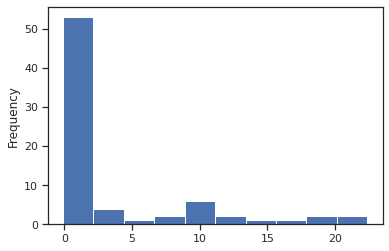

In [4]:
df['NAD+_initial_rate'].plot.hist()

In [5]:
list(df['Sequence'].items())[:2]

[('pSM038',
  'MTKQYKNYVNGEWKLSENEIKIYEPASGAELGSVPAMSTEEVDYVYASAKKAQPAWRALSYIERAAYLHKVADILMRDKEKIGAILSKEVAKGYKSAVSEVVRTAEIINYAAEEGLRMEGEVLEGGSFEAASKKKIAVVRREPVGLVLAISPFNYPVNLAGSKIAPALIAGNVIAFKPPTQGSISGLLLAEAFAEAGLPAGVFNTITGRVSEIGDYIVEHQAVNFINFTGSTGIGERIGKMAGMRPIMLELGGKDSAIVLEDADLELTAKNIIAGAFGYSGQRCTAVKRVLVMESVADELVEKIREKVLALTIGNPEDDADITPLIDTKSADYVEGLINDANDKGATALTEIKREGNLICPILFDKVTTDMRLAWEEPFGPVLPIIRVTSVEEAIEISNKSEYGLQASIFTNDFPRAFGIAEQLEVGTVHINNKTQRGTDNFPFLGAKKSGAGIQGVKYSIEAMTTVKSVVFDIK*'),
 ('pSM050',
  'MTKQYKNYVNGEWKLSENEIKIYEPASGAELGSVPAMSTEEVDYVYASAKKAQPAWRALSYIERAAYLHKVADILMRDKEKIGAILSKEVAKGYKSAVSEVVRTAEIINYAAEEGLRMEGEVLEGGSFEAASKKKIAVVRREPVGLVLAISPFNYPVNLAGSKIAPALIAGNVIAFFPPTQGSISGLLLAEAFAEAGLPAGVFNTITGRGEEIGDYIVEHQAVNFINFTGSTGIGERIGKMAGMRPIMLELGGKDSAIVLEDADLELTAKNIIAGAFGYSGQRCTAVKRVLVMESVADELVEKIREKVLALTIGNPEDDADITPLIDTKSADYVEGLINDANDKGATALTEIKREGNLICPILFDKVTTDMRLAWEEPFGPVLPIIRVTSVEEAIEISNKSEYGLQASIFTNDFPRAFGIAEQLEVGTVHINNKTQRGTDNFPFLGAKKSGAGIQGVKYSIEAMTTVKSVVFDIK*')]

In [6]:
model_name = "esm1_t6_43M_UR50S"
# model_name = "esm1b_t33_650M_UR50S"
torch.hub.set_dir('/tmp/.cache/torch')
# torch.hub.set_dir('/gpfs/alpine/scratch/jlaw/bie108/torch/hub')
# TODO Try this model: esm1v_t33_650M_UR90S
model, alphabet = torch.hub.load("facebookresearch/esm", model_name)

batch_converter = alphabet.get_batch_converter()
batch_labels, batch_strs, batch_tokens = batch_converter(list(df['Sequence'].items()))

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print("Using batch size 8")
batch_dataloader = torch.utils.data.DataLoader(batch_tokens, batch_size=8)

output = []
with torch.no_grad():
    for batch in tqdm(batch_dataloader):
        result = model(batch.to(device), repr_layers=[6])  # because this is the 6-layer transformer
        output += [result['representations'][6].detach().cpu().numpy()]

outputs = np.vstack(output)

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
representations = []
for output, seq in zip(outputs, df['Sequence']):
    representations += [output[1 : len(seq) + 1].mean(0)]
    
representations = np.vstack(representations)
representations.shape

Using cache found in /tmp/.cache/torch/facebookresearch_esm_master


Using batch size 8


100%|██████████| 10/10 [00:00<00:00, 14.96it/s]


(74, 768)

In [61]:
import itertools
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import SVR
# Kernel ridge regression (KRR) combines ridge regression (linear least squares with l2-norm regularization) with the kernel trick.
# https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html
# "The form of the model learned by KRR is identical to support vector regression (SVR). 
# However, different loss functions are used: 
# KRR uses squared error loss while support vector regression uses epsilon-insensitive loss, 
# both combined with l2 regularization. In contrast to SVR, fitting a KRR model can be done in closed-form and is typically faster for medium-sized datasets. On the other hand, the learned model is non-sparse and thus slower than SVR, which learns a sparse model for epsilon > 0, at prediction-time.
from sklearn.kernel_ridge import KernelRidge

# alg = "svr"
alg = 'krr'
kernel = 'laplacian'
# normalize_vals = True
wt_nadph = 41.342
log_transform = True

# now run K-fold CV using ridge regression
X = representations
y = df['NAD+_initial_rate'].astype(float)
# take the exponent of the training data and predicted probabilities so nothing is < 0

y_train_test = y
if normalize_vals:
    y_train_test = np.asarray([max(0,x/41.342) for x in y])
if log_transform:
    y_train_test = np.asarray([np.log(max(1,x)) for x in y])

kf = KFold(n_splits=5, shuffle=True)
print(kf)

alphas = [1e-6, 1e-5, 0.0001, 0.001, 0.01, 0.1, 1, 10]
gammas = [0.01, 0.1, 1, 10, 100]
# alphas = [.01]
repetitions = 10
best_alpha = 0
best_rmse = 10000
best_y_pred = []
# print("model_name\talpha\tgamma\tavg_slope\tavg_mae\tavg_rmse")
print("model_name\talpha\tavg_slope\tavg_mae\tavg_rmse")
# for alpha, gamma in itertools.product(alphas, gammas):
for alpha in alphas:
    y_preds = []
    maes = []
    rmses = []
    slopes = []
    for rep in range(repetitions):
        y_pred = np.zeros(len(y))
        for train_index, test_index in kf.split(X):
        #     print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y_train_test[train_index], y_train_test[test_index]
            if alg == 'krr':
#                 clf = KernelRidge(alpha=alpha, kernel='poly', gamma=gamma)
                clf = KernelRidge(alpha=alpha, kernel=kernel)
            elif alg == "ridge":
                clf = Ridge(alpha=alpha)

            clf.fit(X_train, y_train)
            y_pred[test_index] = clf.predict(X_test)

        y_preds.append(y_pred)
        # mean avg error
        mae = np.sum(np.abs(y_train_test - y_pred))
        # also compute the root mean squared error
        rmse = np.sqrt(np.sum((y_train_test - y_pred)**2) / len(y))
        maes.append(mae)
        rmses.append(rmse)
        # and the slope
        slope, intercept, r_value, p_value, std_err = linregress(y_train_test, y_pred)
        slopes.append(slope)
        
    avg_mae = np.mean(mae)
    avg_slope = np.mean(slopes)
    avg_rmse = np.mean(rmses)
    print(f"{model_name}\t{alpha}\t{gamma}\t{avg_slope:0.2f}\t{avg_mae:0.2f}\t{avg_rmse:0.2f}")
    
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
#         best_alpha = (alpha, gamma)
        best_alpha = alpha
        best_y_pred = y_preds
y_preds = best_y_pred
print(f"best_rmse: {best_rmse:0.2f}, best_alpha: {str(best_alpha)}")

KFold(n_splits=5, random_state=None, shuffle=True)
model_name	alpha	avg_slope	avg_mae	avg_rmse
esm1_t6_43M_UR50S	1e-06	100	0.82	20.11	0.39
esm1_t6_43M_UR50S	1e-05	100	0.83	18.11	0.37
esm1_t6_43M_UR50S	0.0001	100	0.81	17.65	0.39
esm1_t6_43M_UR50S	0.001	100	0.80	21.03	0.40
esm1_t6_43M_UR50S	0.01	100	0.67	26.86	0.49
esm1_t6_43M_UR50S	0.1	100	0.35	42.41	0.74
esm1_t6_43M_UR50S	1	100	0.07	60.37	0.98
esm1_t6_43M_UR50S	10	100	0.00	62.81	1.06
best_rmse: 0.37, best_alpha: 1e-05


In [62]:
if log_transform:
    y_preds = [np.exp(ys) for ys in y_preds]
df2 = pd.DataFrame({'y': np.exp(y_train_test), 'y_pred': np.mean(y_preds, axis=0)})
df2.head(2)

,y,y_pred
0,1.0,1.155363
1,1.0,0.950636


Text(0.5, 0, 'exp(log y)')

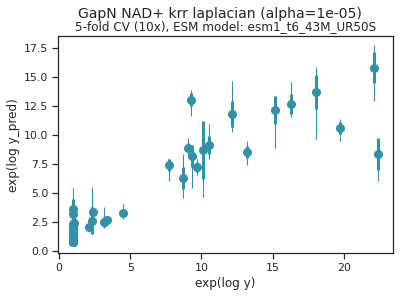

In [63]:
f, ax = plt.subplots()
color = "#3291a8"
std_dev = np.std(y_preds, axis=0)
ax.errorbar(df2['y'], df2['y_pred'], yerr=np.max(y_preds, axis=0) - df2['y_pred'], fmt='o', lolims=True, ms=0, lw=1, ls=None, capsize=.5, ecolor=color)
ax.errorbar(df2['y'], df2['y_pred'], yerr=df2['y_pred'] - np.min(y_preds, axis=0), fmt='o', uplims=True, ms=0, lw=1, ls=None, capsize=.5, ecolor=color)
ax.errorbar(df2['y'], df2['y_pred'], yerr=std_dev, fmt="o", ms=8, lw=3, color=color)
# df2.plot.scatter(x='y', y="y_pred", s=1, ax=ax)
plt.suptitle(f"GapN NAD+ {alg} {kernel} (alpha={best_alpha})", fontsize=14)
ax.set_title(f"5-fold CV ({repetitions}x), ESM model: {model_name}", fontsize=12)
ax.set_ylabel("exp(log y_pred)")
ax.set_xlabel("exp(log y)")

# out_file = f"viz/gapn-nadh-ridge-{model_name}.svg"
# print(out_file)
# os.makedirs(os.path.dirname(out_file), exist_ok=True)
# plt.savefig(out_file, bbox_inches='tight')
# plt.savefig(out_file.replace('.svg','.png'), bbox_inches='tight')
# plt.savefig(out_file.replace('.svg','.pdf'), bbox_inches='tight')

(array([ 7.,  7.,  8.,  7.,  9.,  7., 13.,  8.,  3.,  5.]),
 array([-1.93407059, -0.82428169,  0.2855072 ,  1.3952961 ,  2.50508499,
         3.61487389,  4.72466278,  5.83445168,  6.94424057,  8.05402946,
         9.16381836]),
 <BarContainer object of 10 artists>)

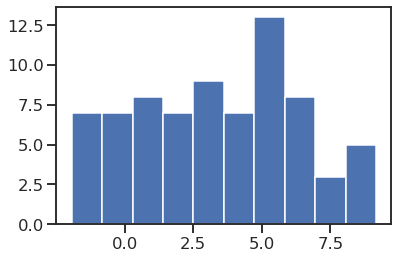

In [21]:
plt.hist(y_pred)
